# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [2]:
DATASET = 'GTSRB'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [3]:
# print available models
for i in (base / 'experiments' / DATASET / 'saved-models').iterdir():
    if i.name[:len(DATASET)] == DATASET:
        print(i.name.replace(DATASET + '_', ''))

AdamW-32-50
AdamW-32-150
AdamW-32-30
AdamW-32-80


In [4]:
POSTFIX = 'AdamW-32-30'
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

In [5]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastprogress import progress_bar

In [7]:
from utilities.utils import load_json, load_pickle, split_data
from utilities.pathManager import fetchPaths

# Paths

In [8]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

# Seed

In [9]:
np.random.seed(SEED)

# Import Data

In [10]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")
df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")

# LHL

In [11]:
# sample_indecies = split_data(df_train['y'], 0.2)
sample_indecies = df_train.index

In [12]:
# df_train.loc[df_train_sample, 'y'].value_counts()

In [13]:
df_train_sample = df_train.loc[sample_indecies].reset_index(drop=True)

y_sample = df_train_sample['y']
true_sample = df_train_sample['true']

df_train_sample = df_train_sample.drop(['y', 'true'], axis=1).to_numpy()

### Scalers

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [15]:
scale = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()


scale_sample = scale.fit_transform(df_train_sample)
minmax_sample = minmax.fit_transform(df_train_sample)
robust_sample = robust.fit_transform(df_train_sample)

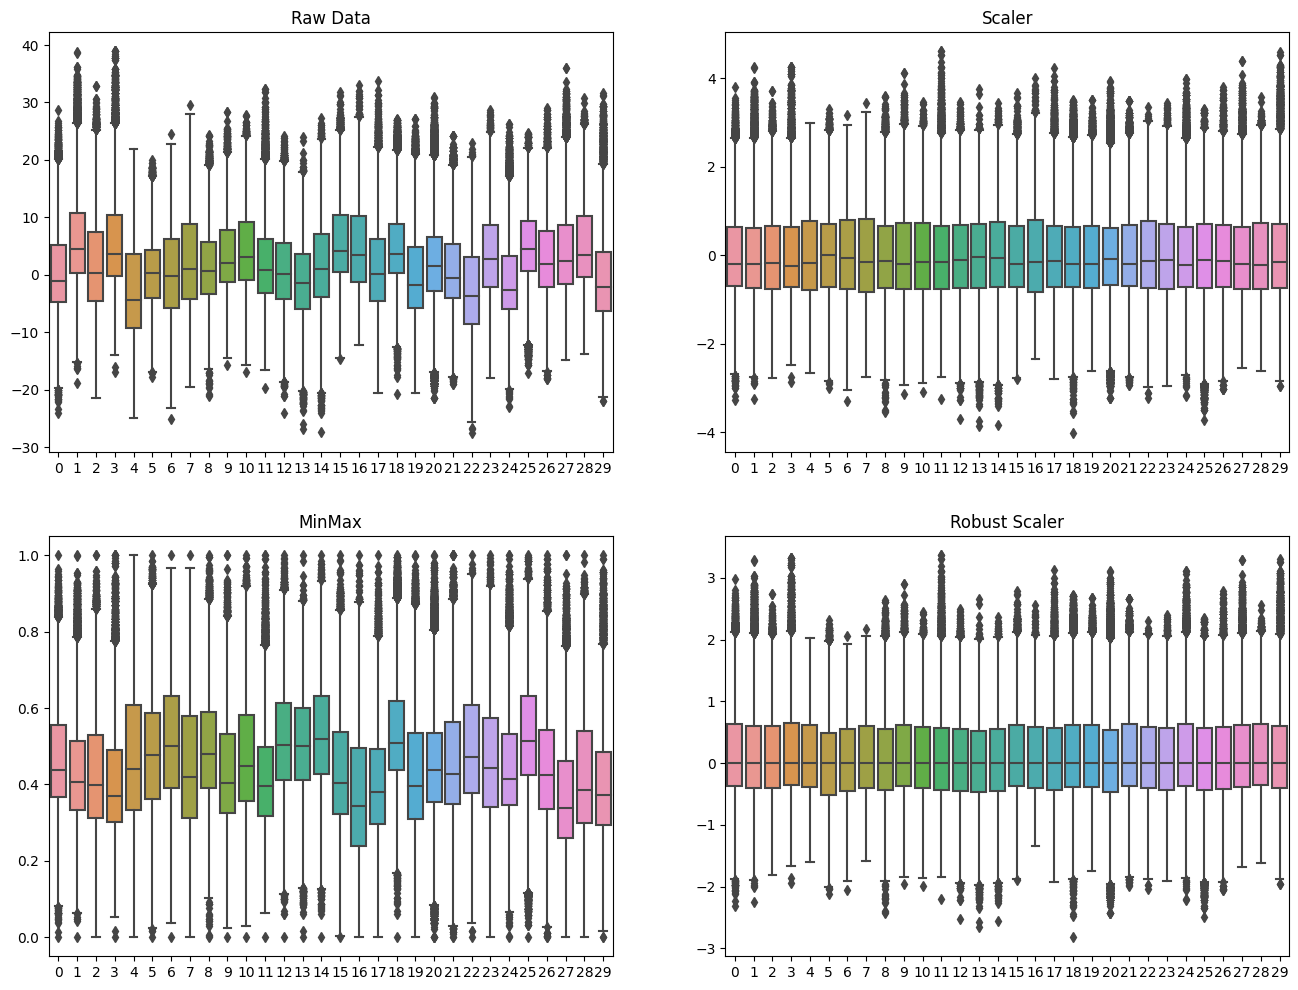

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(df_train_sample, ax=ax[0, 0])
sns.boxplot(scale_sample, ax=ax[0, 1])
sns.boxplot(minmax_sample, ax=ax[1, 0])
sns.boxplot(robust_sample, ax=ax[1, 1])

ax[0,0].set_title('Raw Data')
ax[0,1].set_title('Scaler')
ax[1,0].set_title('MinMax')
ax[1,1].set_title('Robust Scaler')

plt.show()

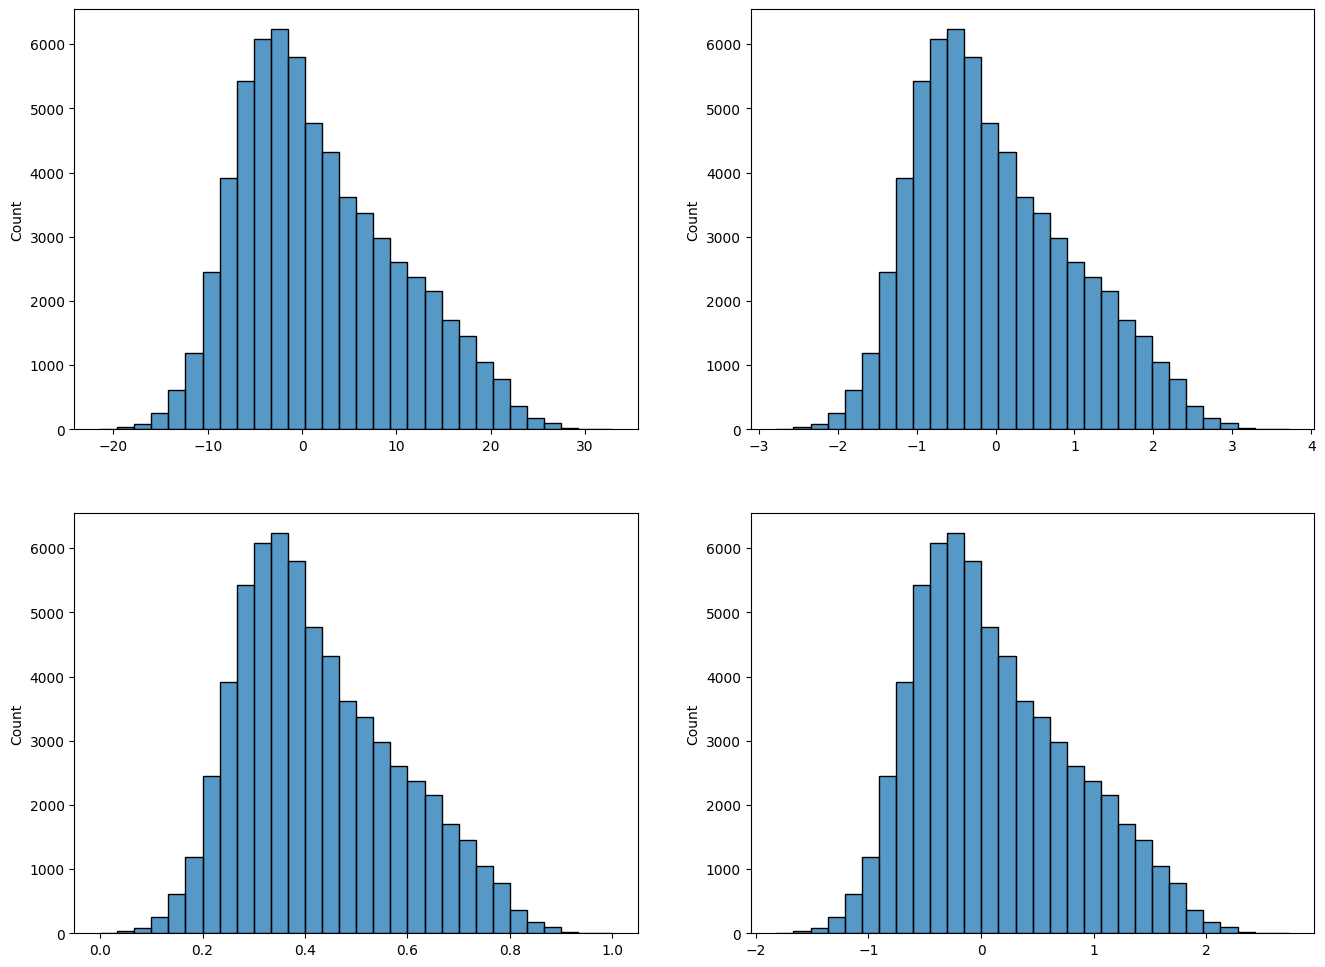

In [17]:
neuron = 2
bins=30

fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.histplot(df_train_sample[:, neuron], bins=bins, ax=ax[0, 0])
sns.histplot(scale_sample[:, neuron], bins=bins, ax=ax[0, 1])
sns.histplot(minmax_sample[:, neuron], bins=bins, ax=ax[1, 0])
sns.histplot(robust_sample[:, neuron], bins=bins, ax=ax[1, 1])


plt.show()

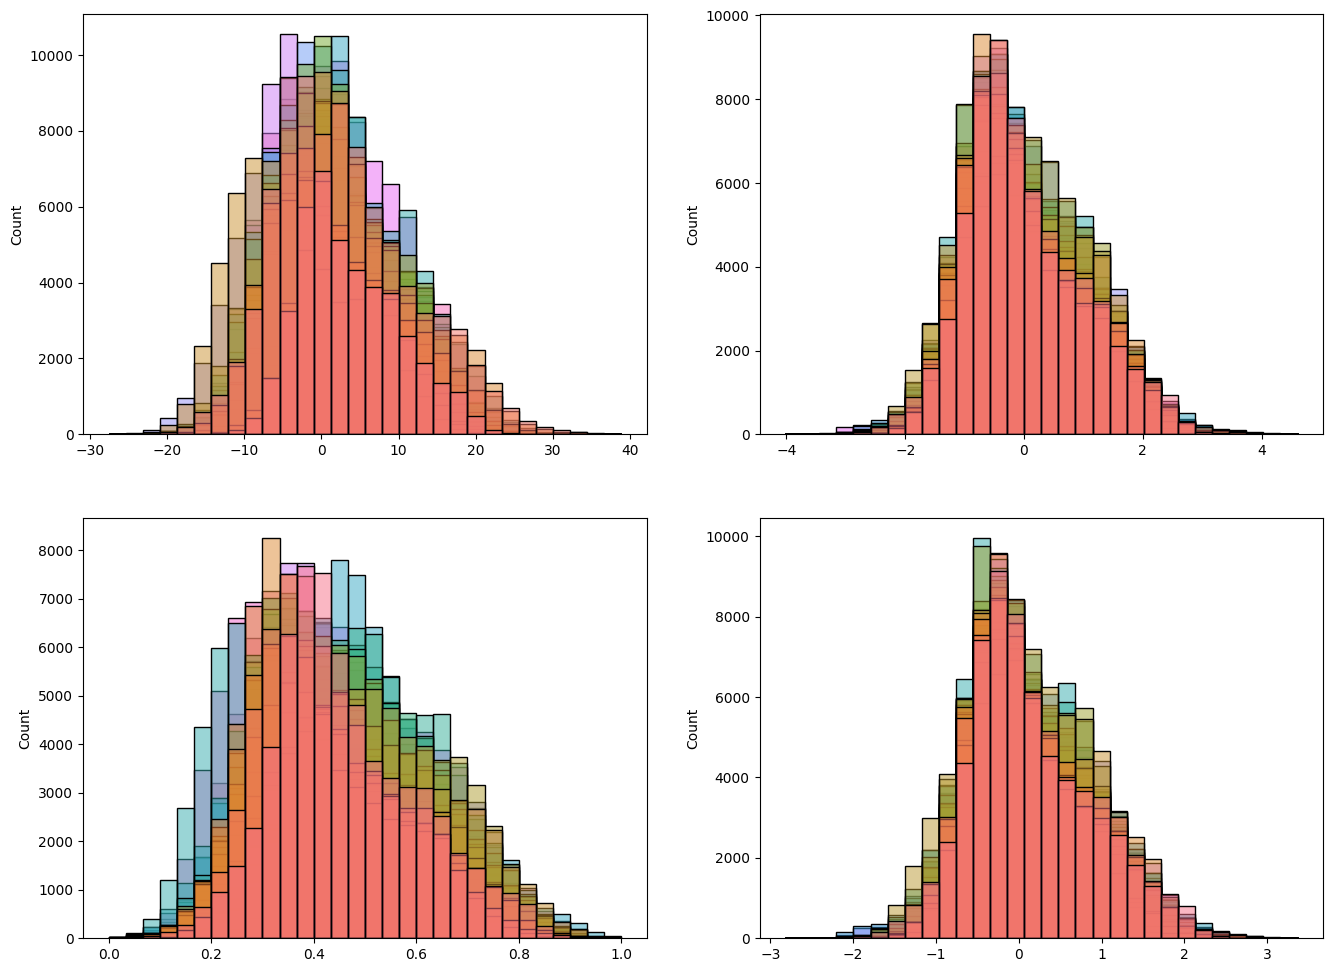

In [18]:
bins=30

fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.histplot(df_train_sample, bins=bins, ax=ax[0, 0])
sns.histplot(scale_sample, bins=bins, ax=ax[0, 1])
sns.histplot(minmax_sample, bins=bins, ax=ax[1, 0])
sns.histplot(robust_sample, bins=bins, ax=ax[1, 1])

for a in ax.flatten(): a.get_legend().remove()

plt.show()

## Normal Dist test

[D’Agostino and Pearson’s](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#r7bf2e556f491-1)

In [19]:
from scipy.stats import normaltest

In [20]:
p_value_thld = 1e-2

In [21]:
normality_test = pd.DataFrame({
    'neurons': df_train.drop(['y', 'true'], axis=1).columns,
    'raw': normaltest(df_train_sample).pvalue <  p_value_thld,
    'scalar': normaltest(scale_sample).pvalue <  p_value_thld,
    'minmax': normaltest(minmax_sample).pvalue <  p_value_thld,
    'robust': normaltest(robust_sample).pvalue <  p_value_thld
})

In [22]:
normality_test.iloc[:, 1:].all()

raw       True
scalar    True
minmax    True
robust    True
dtype: bool

### PCA

In [23]:
from sklearn.decomposition import PCA

In [24]:
pca_train = PCA()
pca_scale = PCA()
pca_minmax = PCA()
pca_robust = PCA()


pca_df_train = pca_train.fit_transform(df_train_sample)
pca_df_scale = pca_scale.fit_transform(scale_sample)
pca_df_minmax = pca_minmax.fit_transform(minmax_sample)
pca_df_robust = pca_robust.fit_transform(robust_sample)

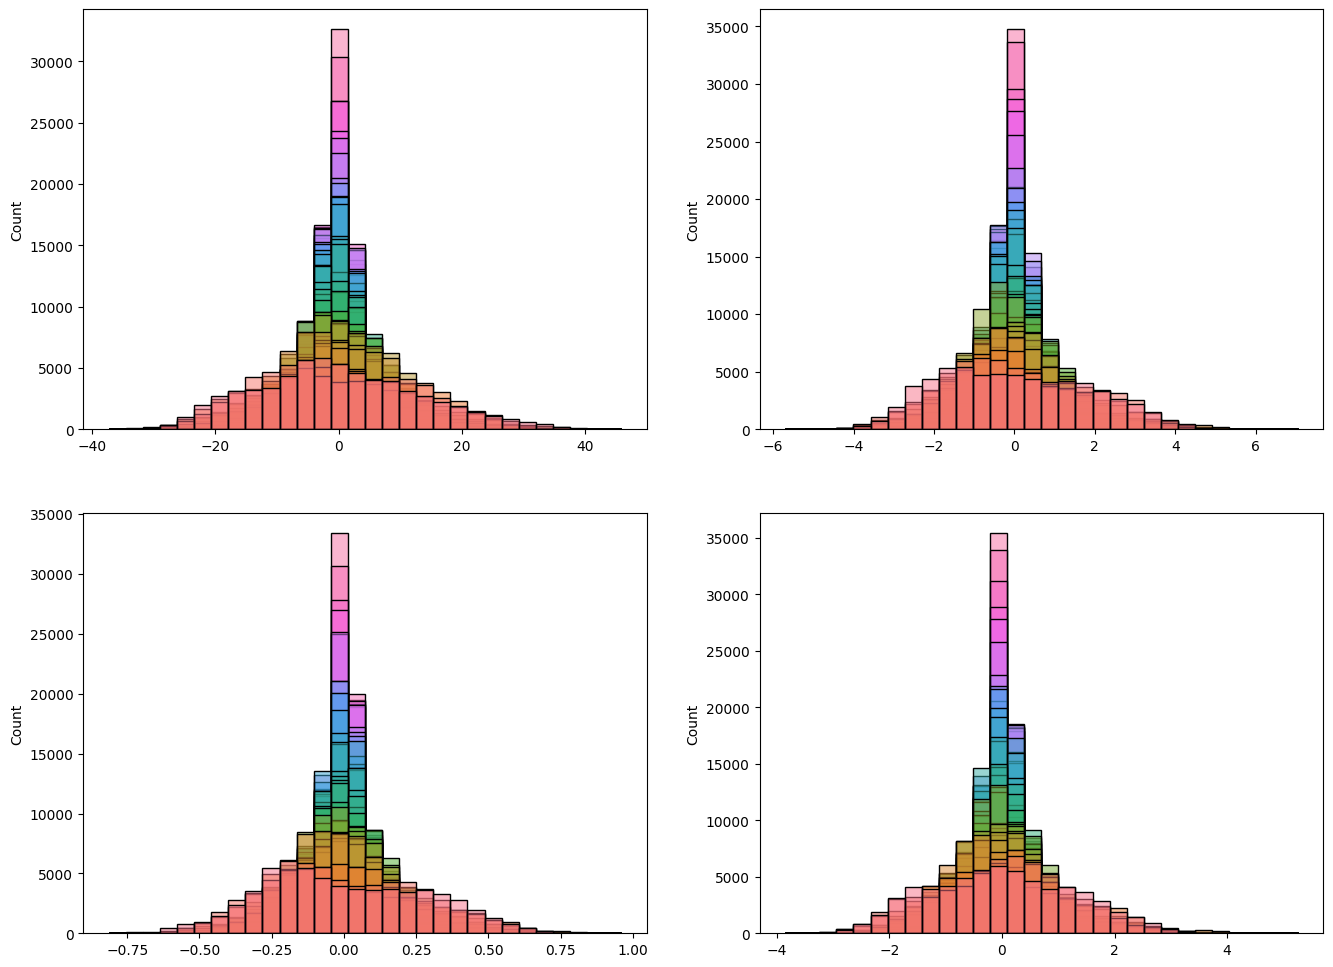

In [25]:
bins=30

fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.histplot(pca_df_train, bins=bins, ax=ax[0, 0])
sns.histplot(pca_df_scale, bins=bins, ax=ax[0, 1])
sns.histplot(pca_df_minmax, bins=bins, ax=ax[1, 0])
sns.histplot(pca_df_robust, bins=bins, ax=ax[1, 1])

for a in ax.flatten(): a.get_legend().remove()

plt.show()

### PCA Loadings

In [26]:
var_thld = 0.9
numNeurons = df_train_sample.shape[1]

In [27]:
num_component = sum(np.cumsum(pca_scale.explained_variance_ratio_).round(2) <= var_thld)

pca_scale_components = pd.DataFrame(
    pca_scale.components_[:,:num_component],
    columns=[f'PC_{i}' for i in range(1, num_component+1)],
    index=[f'x{i}' for i in range(numNeurons)]
)

pca_scale_loadings = (pca_scale_components * np.sqrt(pca_scale.explained_variance_[:num_component])).abs()

<Axes: >

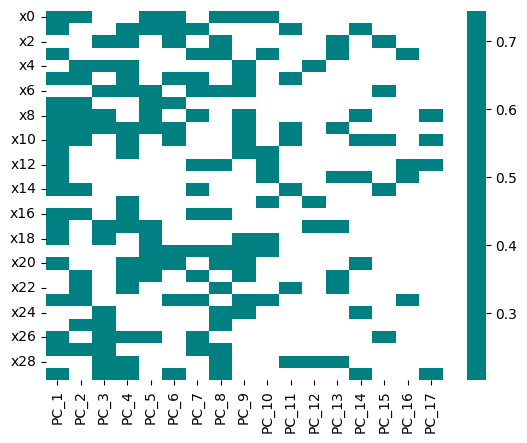

In [28]:
sns.heatmap(pca_scale_loadings, mask=pca_scale_loadings<0.2, cmap=['teal'])

In [29]:

# neurons_loadings = (pca_scale_loadings.abs() >= loadings_thld).any(axis=1)
# neurons[cls] = neurons_loadings[neurons_loadings == True].index.tolist()

In [30]:
pca_scale_loadings.describe()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.280036,0.253645,0.236527,0.242623,0.209996,0.199368,0.213781,0.186045,0.188498,0.165325,0.143939,0.132579,0.135285,0.121775,0.124406,0.118768,0.102779
std,0.189693,0.201448,0.201846,0.154063,0.158111,0.157547,0.116884,0.139806,0.122249,0.118178,0.122028,0.112697,0.086299,0.097555,0.083360,0.088621,0.075351
min,0.010724,0.014379,0.014754,0.027024,0.014594,0.020929,0.071623,0.004147,0.003617,0.006294,0.000593,0.014156,0.000385,0.000860,0.014149,0.001829,0.014388
25%,0.152588,0.086567,0.066388,0.115144,0.099388,0.082643,0.125117,0.070409,0.095818,0.070695,0.048200,0.054621,0.078308,0.053483,0.051735,0.047479,0.050796
50%,0.251634,0.164979,0.149244,0.217216,0.168700,0.174696,0.183209,0.173355,0.185232,0.124286,0.113761,0.120260,0.126079,0.087926,0.110484,0.096654,0.073474
75%,0.434254,0.412066,0.421196,0.352817,0.297337,0.263657,0.302793,0.268488,0.268113,0.240478,0.186567,0.166830,0.196315,0.185732,0.178424,0.165605,0.153231
max,0.721517,0.682691,0.658480,0.552113,0.693193,0.744684,0.523411,0.501972,0.495339,0.462185,0.479167,0.481492,0.305724,0.343289,0.321237,0.340589,0.302199


In [31]:
pca_scale.explained_variance_ratio_

array([0.11320243, 0.10356284, 0.09532694, 0.08180865, 0.0682628 ,
       0.06374021, 0.05890793, 0.05350617, 0.04997746, 0.04083222,
       0.03511234, 0.02985391, 0.02550091, 0.02402838, 0.02219382,
       0.02169735, 0.01605188, 0.01403473, 0.01273518, 0.01151443,
       0.00971217, 0.0083185 , 0.00776974, 0.00759045, 0.00533583,
       0.00509518, 0.00438136, 0.0039338 , 0.0032829 , 0.00272948])

In [32]:
pca_scale_loadings

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
x0,0.411178,0.395122,0.134415,0.059547,0.299480,0.228865,0.071623,0.466049,0.260743,0.324128,0.031202,0.033864,0.085329,0.165064,0.031878,0.038686,0.029889
x1,0.261544,0.065231,0.110560,0.346705,0.369235,0.357833,0.451521,0.082482,0.026410,0.131492,0.298328,0.168490,0.031722,0.276576,0.182809,0.095542,0.187028
x2,0.019132,0.093762,0.653722,0.338030,0.165921,0.227779,0.088556,0.238781,0.003617,0.020574,0.094116,0.014156,0.296501,0.008424,0.217559,0.165543,0.120505
x3,0.269077,0.101538,0.073581,0.143907,0.026362,0.122379,0.305735,0.255106,0.069387,0.243665,0.090215,0.146062,0.203268,0.040656,0.131031,0.340589,0.064973
x4,0.033835,0.682691,0.514613,0.217756,0.144496,0.032302,0.189762,0.011405,0.382362,0.060210,0.015848,0.481492,0.172051,0.089755,0.014149,0.035616,0.025999
x5,0.498829,0.411563,0.164074,0.525769,0.083486,0.292826,0.212458,0.168859,0.215625,0.045681,0.402685,0.150927,0.149349,0.075998,0.077057,0.026134,0.181071
x6,0.144587,0.162781,0.448682,0.467695,0.290906,0.191927,0.302847,0.259129,0.295708,0.070317,0.152941,0.029729,0.007102,0.036695,0.254023,0.038338,0.014388
x7,0.229244,0.269001,0.103508,0.183464,0.388525,0.419645,0.123231,0.045228,0.092261,0.110640,0.000593,0.033363,0.108675,0.000860,0.040301,0.077272,0.116608
x8,0.721517,0.465944,0.237425,0.182822,0.284572,0.132004,0.225190,0.118417,0.330993,0.195336,0.057512,0.027353,0.087637,0.250819,0.034269,0.074010,0.204929
x9,0.241724,0.304020,0.349451,0.203449,0.376946,0.290229,0.135348,0.091753,0.223269,0.188846,0.263874,0.019236,0.218940,0.039289,0.020848,0.074931,0.144025


In [33]:
(pca_scale_loadings >= 0.2).any(axis=1).index.shape

(30,)

In [34]:
var_expl_comp = (pca_scale.explained_variance_[:num_component] / pca_scale.explained_variance_[:num_component].sum())
var_expl_comp

array([0.12528404, 0.11461565, 0.10550078, 0.09053974, 0.0755482 ,
       0.07054293, 0.06519492, 0.05921665, 0.05531134, 0.04519007,
       0.03885973, 0.03304009, 0.02822251, 0.02659283, 0.02456247,
       0.02401301, 0.01776503])

In [35]:
var_expl_comp_num = (var_expl_comp.round(2) >= 5e-2).sum()
var_expl_comp_num

10

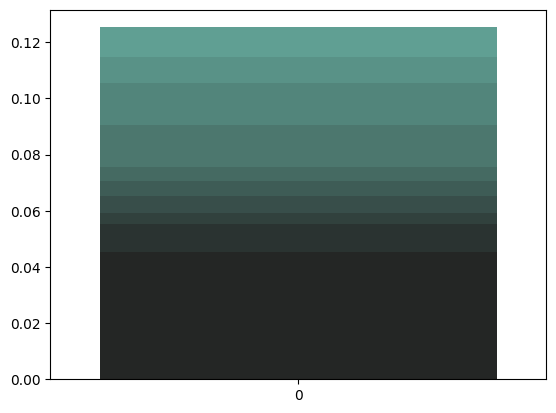

In [36]:
palette=sns.color_palette("dark:#5A9_r", var_expl_comp_num)

for i, e in zip(range(var_expl_comp_num), var_expl_comp[:var_expl_comp_num]):
    sns.barplot(x=[0] , y=[e], palette=[palette[i]])

In [37]:
neuron_loadings = ((pca_scale_loadings >= 0.2) * var_expl_comp).sum(axis=1)
neuron_loadings

x0     0.545709
x1     0.492562
x2     0.378585
x3     0.347121
x4     0.399008
x5     0.560348
x6     0.475874
x7     0.385991
x8     0.585813
x9     0.704425
x10    0.564074
x11    0.316325
x12    0.336664
x13    0.249302
x14    0.368517
x15    0.168770
x16    0.454851
x17    0.458135
x18    0.406834
x19    0.371004
x20    0.503036
x21    0.429432
x22    0.331454
x23    0.500152
x24    0.246622
x25    0.279333
x26    0.486630
x27    0.469812
x28    0.355379
x29    0.495442
dtype: float64

In [38]:
neuron_loadings.describe()

count    30.000000
mean      0.422240
std       0.115555
min       0.168770
25%       0.349186
50%       0.418133
75%       0.494722
max       0.704425
dtype: float64

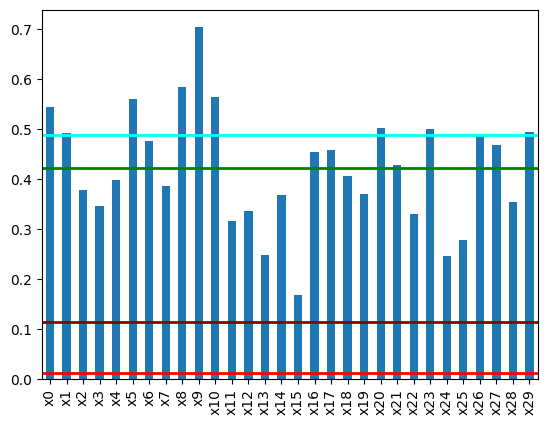

In [39]:
neuron_loadings.plot.bar()

plt.axhline(neuron_loadings.quantile(0.7), color='aqua', linewidth=2, label='Qt 7')
plt.axhline(neuron_loadings.mean(), color='green', linewidth=2, label='Mean')
plt.axhline(neuron_loadings.std(), color='darkred', linewidth=2, label='Std')
plt.axhline(neuron_loadings.var(), color='red', linewidth=2, label='Var')

plt.show()

In [40]:
set(neuron_loadings.sort_values(ascending=False)[:10].index.to_list())

{'x0', 'x1', 'x10', 'x20', 'x23', 'x26', 'x29', 'x5', 'x8', 'x9'}

In [41]:
set(neuron_loadings[neuron_loadings >= neuron_loadings.mean()].index.to_list())

{'x0',
 'x1',
 'x10',
 'x16',
 'x17',
 'x20',
 'x21',
 'x23',
 'x26',
 'x27',
 'x29',
 'x5',
 'x6',
 'x8',
 'x9'}

In [42]:
df_train_sample.shape

(63968, 30)

In [43]:
def fitStandardScalerSingle(df, numNeurons):
    """
    Fit StandardScaler to dataframe and ignore columns after numNeurons
    Return: scaler object"""

    scaler = StandardScaler()
    scaler.fit(df.iloc[:, :numNeurons])

    return scaler

def applyStandardScalerSingle(df, numNeurons, scaler=None):
    """Apply scaler to dataframe"""

    return_scaler = False
    if scaler is None:
        scaler = fitStandardScalerSingle(df, numNeurons)
        return_scaler = True

    numNeurons = scaler.n_features_in_
    dfScaler = pd.DataFrame( scaler.transform(df.iloc[:, :numNeurons]), columns=df.columns[:numNeurons] )
    # readd non neuron columns
    for col in df.columns[numNeurons:].tolist():
        dfScaler[col] = df[col].to_numpy()

    if return_scaler:
        return scaler, dfScaler

    return dfScaler

In [44]:
def fitPCASingle(df, scaler=None, numNeurons=None):

    if scaler is not None: numNeurons = scaler.n_features_in_
    pca_ = PCA(n_components=numNeurons)
    df = df[df.columns[:numNeurons]]

    if scaler is not None:
        df = scaler.transform(df)

    pca_.fit(df)

    return pca_

def applyPCASingle(df, scaler=None, pca=None, numNeurons=None):

    return_pca = False
    if pca is None:
        return_pca = True
        pca = fitPCASingle(df, scaler, numNeurons)

    if numNeurons is None: numNeurons = pca.n_components
    temp = df[df.columns[:numNeurons]]
    if scaler is not None:
        temp = scaler.transform(temp)
    temp = pd.DataFrame( pca.transform(temp), columns=[f'PC{i}' for i in range(1, numNeurons+1)] )

    for col in df.columns[numNeurons:].tolist():
        temp[col] = df[col].to_numpy()

    if return_pca:
        return pca, temp

    return temp


def neuronsLoadingsSingle(pca, numNeurons=None, var_thld=0.9, loadings_thld=0.2, expl_var_thld=0.05):

    num_component = sum(np.cumsum(pca.explained_variance_ratio_).round(2) <= var_thld)
    if numNeurons is None: numNeurons = pca.n_components

    pca_components = pd.DataFrame(
        pca.components_[:,:num_component],
        columns=[f'PC_{i}' for i in range(1, num_component+1)],
        index=[f'x{i}' for i in range(1, numNeurons+1)]
    )

    pca_loadings = (pca_components * np.sqrt(pca.explained_variance_[:num_component])).abs()
    var_expl_component = (pca.explained_variance_[:num_component] / pca.explained_variance_[:num_component].sum())
    neuron_loadings = ((pca_loadings >= loadings_thld) * var_expl_component).sum(axis=1)

    gte_mean = neuron_loadings[neuron_loadings >= neuron_loadings.mean()].index.to_list()
    top_third =neuron_loadings.sort_values(ascending=False)[:numNeurons // 3].index.to_list()

    return gte_mean, top_third

In [45]:
# from utilities.scaleFunctions import applyStandardScalerSingle
# from utilities.pcaFunctions import applyPCASingle, numComponents, neuronsLoadingsSingle

In [46]:
scaler, scaled_data = applyStandardScalerSingle(pd.DataFrame(df_train_sample), df_train_sample.shape[1])

In [47]:
pca, pca_data = applyPCASingle(pd.DataFrame(df_train_sample), scaler)

In [48]:
(pca.components_ == pca_scale.components_).all().all()

True

In [49]:
(pca.explained_variance_ == pca_scale.explained_variance_).all().all()

True

In [50]:
gte_mean, top_third = neuronsLoadingsSingle(pca)

In [51]:
set(gte_mean) - set(neuron_loadings[neuron_loadings >= neuron_loadings.mean()].index.to_list())

{'x11', 'x18', 'x2', 'x22', 'x24', 'x28', 'x30', 'x7'}